## Implementing CBOW algorithm with Negative Sampling
<u>Goal: </u> Predict from 2 words the inner word
i.e. I'll have a window like ["a", "b", "c"] of continuous text (each is a word)

Use wc=["a", "c"] to predict "b" = wo

<u> Note: </u>  could predict each of wo = ["a", "c"] from "b" = wc for Skip-Gram

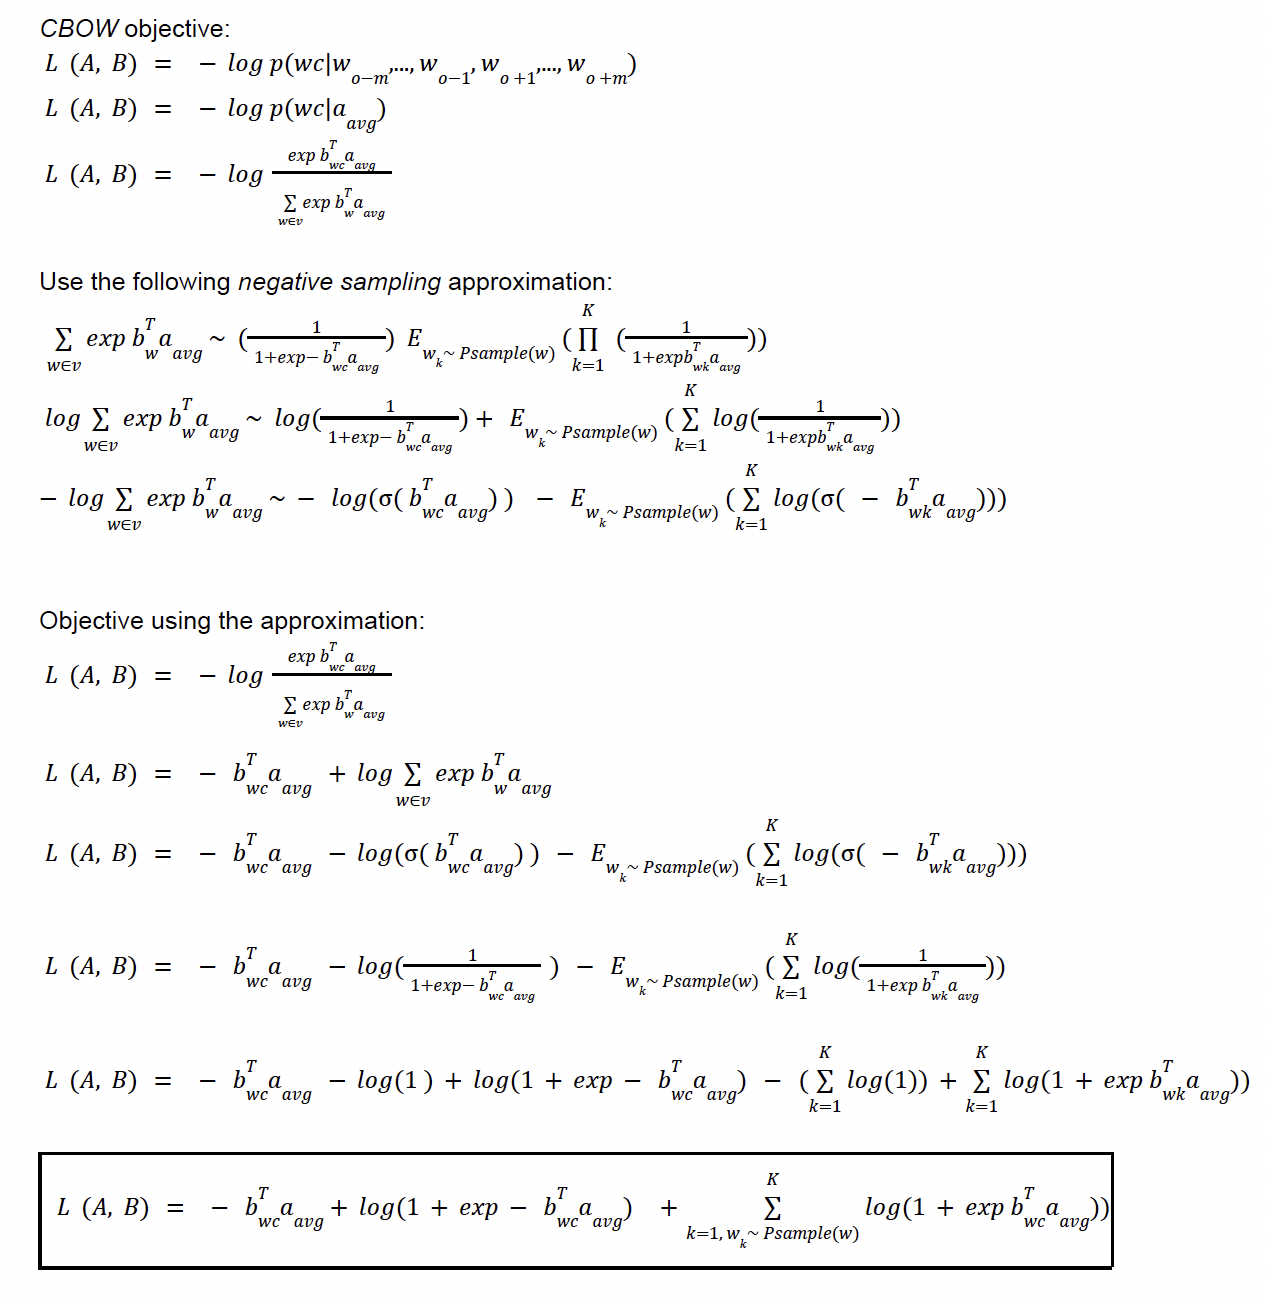

In [1]:
# Imports
import time
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchtext.data.utils import get_tokenizer
from torchtext.datasets import DATASETS
from torchtext.vocab import build_vocab_from_iterator
import torch.nn as nn
from tqdm import tqdm
import pickle
import random
import numpy as np
from collections import Counter, defaultdict
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
import gensim.downloader
from torch import FloatTensor as FT
from google.colab import drive
drive.mount('/content/gdrive')

# Get the interactive Tools for Matplotlib
%matplotlib notebook
%matplotlib inline
plt.style.use('ggplot')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# Initialize some variables
DEVICE = "cuda" if torch.cuda.is_available() else  "cpu"

# The batch size in Adam or SGD
BATCH_SIZE = 512

# Number of epochs
NUM_EPOCHS = 10

# Size of window t-w,..,t+w
WINDOW = 1

# Number of negative samples
K = 4

### Prepare the Vocabulary/Tokenize Text

In [8]:
# Loading data
# The text8 Wikipedia corpus. 100M characters.
dir=f'/content/gdrive/My Drive/text8.txt'
f = open(dir, 'r')
text = f.read()
# One big string of size 100M
print("Length of text:", len(text))
punc = '!"#$%&()*+,-./:;<=>?@[\\]^_\'{|}~\t\n'

# Can do regular expressions here too
for c in punc:
    if c in text:
        text.replace(c, ' ')

# A very crude tokenizer you get for free: lower case and also split on spaces
TOKENIZER = get_tokenizer("basic_english")
words = TOKENIZER(text)
f = Counter(words)

# Do a very crude filter on the text which removes all very popular words
text = [word for word in words if f[word] > 5]

VOCAB = build_vocab_from_iterator([text])

# word -> int hash map
stoi = VOCAB.get_stoi()
# int -> word hash map
itos = VOCAB.get_itos()

# Total number of words
print("Total number of words:", len(stoi))

Length of text: 16680599
Total number of words: 63641


In [7]:
# Probability that word is kept while subsampling
# This is explained here and sightly differet from the original paper: http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/
f = Counter(words)
z = {word: f[word] / len(text) for word in f}
p_keep = {word: (np.sqrt(z[word] / 0.001) + 1)*(0.0001 / z[word]) for word in f}

# This is in the integer space
train_dataset = [word for word in text if random.random() < p_keep[word]]

# Rebuild the vocabulary
VOCAB = build_vocab_from_iterator([train_dataset])

# word -> int mapping
stoi = VOCAB.get_stoi()
# int -> word mapping
itos = VOCAB.get_itos()

print("Length training set:",len(train_dataset))
print("Total number of words:",len(stoi))

Length training set: 7847080
Total number of words: 63641


In [9]:
# Downsample frequent words and upsample less frequent
# The probability we draw something for negative sampling
f = Counter(train_dataset)
p = torch.zeros(len(VOCAB))
s = sum([np.power(freq, 0.75) for word, freq in f.items()])

for word in f:
    p[stoi[word]] = np.power(f[word], 0.75) / s

# Map everything to integers
train_dataset = [stoi[word] for word in text]
print("Length training set:",len(train_dataset))

Length training set: 16680599


In [10]:
# This just gets the (wc, wo) pairs that are positive - they are seen together!
def get_tokenized_dataset(dataset, verbose=False):
    x_list = []

    for i, token in enumerate(dataset):
        m = 1

        # Get the left and right tokens
        start = i +m
        left_tokens = dataset[i: start]

        end = start + 1 +m
        right_tokens = dataset[start +1: end]

        # Check these are the same length, and if so use them to add a row of data. This should be a list like
        # [a, c, b] where b is the center word
        if len(left_tokens) == len(right_tokens):
            w_context = left_tokens+right_tokens

            wc =  dataset[start:start +1]

            x_list.extend(
                [w_context+wc]
            )

    return x_list

train_x_list = get_tokenized_dataset(train_dataset, verbose=False)
# The number of things of BATCH_SIZE = 512
assert(len(train_x_list) // BATCH_SIZE == 32579)

pickle.dump(train_x_list, open('train_x_list.pkl', 'wb'))
# train_x_list = pickle.load(open('train_x_list.pkl', 'rb'))
# These are (wc, wo) pairs. All are y = +1 by design
train_x_list[:10]

[[5233, 11, 3083],
 [3083, 5, 11],
 [11, 167, 5],
 [5, 1, 167],
 [167, 3133, 1],
 [1, 45, 3133],
 [3133, 57, 45],
 [45, 134, 57],
 [57, 122, 134],
 [134, 741, 122]]

In [11]:
# Set up the dataloader
train_dl = DataLoader(
    TensorDataset(
        torch.tensor(train_x_list).to(DEVICE),
    ),
    batch_size=BATCH_SIZE,
    shuffle=True
)
# Peak at the training data
for xb in train_dl:
    print(xb)
    assert(xb[0].shape == (BATCH_SIZE, 3))
    break

[tensor([[   28, 17041,     0],
        [   14,   813,   268],
        [    9,  6403,    51],
        ...,
        [    6, 16277,   733],
        [   76,     0, 42029],
        [   95,     1,   935]], device='cuda:0')]


### Define the model: CBOW with Negative Sampling

In [12]:
class CBOWNegativeSampling(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(CBOWNegativeSampling, self).__init__()
        self.A = nn.Embedding(vocab_size, embed_dim) # Context vectors - center word
        self.B = nn.Embedding(vocab_size, embed_dim) # Output vectors - words around the center word
        self.init_weights()

    def init_weights(self):
        # Is this the best way? Probably not
        initrange = 0.5
        self.A.weight.data.uniform_(-initrange, initrange)
        self.B.weight.data.uniform_(-initrange, initrange)

    def forward(self, x):
        # N is the batch size
        # x is (N, 3)

        # Context words are 2m things, m = 1 so w_context is (N, 2) while wc is N
        w_context, wc = x[:, 0:2],x[:,2:]

        # Each of these is (N, 2, D) since each context has 2 word
        # We want this to be (N, D) and this is what we get

        # (N, 2, D)
        a = self.A(w_context)

        # (N, D)
        a_avg = a.sum(axis=1)/2

        # Each of these is (N, D) since each target has 1 word
        b =  self.B(wc)
        b=b.squeeze()

        # The product between each context and target vector. Look at the Skip-Gram code.
        # The logits is now (N, 1) since we sum across the final dimension.
        logits = (a_avg * b).sum(axis=-1)

        return logits

### Model validation

In [13]:
# Words we'll use to asses the quality of the model ...
valid_ids = torch.tensor([
    stoi['money'],
    stoi['lion'],
    stoi['africa'],
    stoi['musician'],
    stoi['dance'],
])

@torch.no_grad()
def validate_embeddings(
    model,
    valid_ids,
    itos
):
    """ Validation logic """

    # We will use context embeddings to get the most similar words
    # Other strategies include: using target embeddings, mean embeddings after avaraging context/target
    embedding_weights = model.A.weight

    normalized_embeddings = embedding_weights.cpu() / np.sqrt(
        np.sum(embedding_weights.cpu().numpy()**2, axis=1, keepdims=True)
    )

    # Get the embeddings corresponding to valid_term_ids
    valid_embeddings = normalized_embeddings[valid_ids, :]

    # Compute the similarity between valid_term_ids (S) and all the embeddings (V)
    # We do S x d (d x V) => S x D and sort by negative similarity
    top_k = 10 # Top k items will be displayed
    similarity = np.dot(valid_embeddings.cpu().numpy(), normalized_embeddings.cpu().numpy().T)

    # Invert similarity matrix to negative
    # Ignore the first one because that would be the same word as the probe word
    similarity_top_k = np.argsort(-similarity, axis=1)[:, 1: top_k+1]

    # Print the output.
    for i, word_id in enumerate(valid_ids):
        # j >= 1 here since we don't want to include the word itself.
        similar_word_str = ', '.join([itos[j] for j in similarity_top_k[i, :] if j >= 1])
        print(f"{itos[word_id]}: {similar_word_str}")

    print('\n')

### Training the model

In [14]:
LR = 10.0
EMBED_DIM = 300
model = CBOWNegativeSampling(len(VOCAB), EMBED_DIM).to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
# The learning rate is lowered every epoch by 1/10.
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.1)
print("The model:",model)

ratios = []

def train(dataloader, model, optimizer, epoch):
    model.train()
    total_acc, total_count, total_loss, total_batches = 0, 0, 0.0, 0.0
    log_interval = 500

    for idx, x_batch in tqdm(enumerate(dataloader)):

      x_batch = x_batch[0]

      batch_size = x_batch.shape[0]

      # Zero the gradient so they don't accumulate
      optimizer.zero_grad()

      logits = model(x_batch)
      # Get the positive samples loss. Notice we use weights here
      positive_loss = torch.nn.BCEWithLogitsLoss()(input=logits, target=torch.ones(batch_size).to(DEVICE).float())

      # For each batch, get some negative samples
      # We need a total of len(y_batch) * K samples across a batch
      # We then reshape this batch
      # These are effectively the output words
      negative_samples = torch.multinomial(p, batch_size * K, replacement=True)

      # Context words are 2m things, m = 1 so w_context is (N, 2) while wc is (N, )
      w_context, wc = x_batch[:, 0:2].to("cpu"),x_batch[:,2:].to("cpu")

      """
      if w_context looks like below (batch_size = 3)
      [
      (a, b),
      (c, d),
      (e, f)
      ] and K = 2 we'd like to get:

      [
      (a, b),
      (a, b),
      (c, d),
      (c, d),
      (e, f),
      (e, f)
      ]

      This will be batch_size * K rows.
      """
      # This should be (N * K, 2)
      w_context = torch.concat([
          w.repeat(K, 1) for w in torch.tensor(w_context).split(1)
      ])

      # Add a last dimension and set wc to the negative samples
      wc = negative_samples.unsqueeze(1)

      # Get the negative samples. This should be (N * K, 3)
      # Concatenate the w_context and wc along the column. Make sure everything is on CUDA / MPS or CPU
      x_batch_negative =  torch.hstack([w_context,wc]).to(DEVICE)

      """ Numbers
      Note the way we formulated the targets: they are all 0 since these are negative samples.
      We do the BCEWithLogitsLoss by hand basically here.
      Notice we sum across the negative samples, per positive word.
      """

      # (N, K, D) -> (N, D) -> (N)

      negative_loss = model(x_batch_negative).neg().sigmoid().log().reshape(
              batch_size, K
          ).sum(1).mean().neg().to(DEVICE)

      loss = (positive_loss + negative_loss).mean()


      # Get the gradients via back propagation
      loss.backward()

      # Clip the gradients? Generally a good idea
      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)

      # Used for optimization. This should be roughly 0.001, on average
      # You can use this to see if your learning rate is right - you can also plot the loss performance
      # with torch.no_grad():
      #     r = [
      #         (LR * p.grad.std() / p.data.std()).log10().item() for _, p in model.named_parameters()
      #     ]
      #     ratios.append(r)

      # Do an optimization step. Update the parameters A and B
      optimizer.step()
      # Get the new loss.
      total_loss += loss.item()
      # Update the batch count
      total_batches += 1

      if idx % log_interval == 0:
          print(
              "| epoch {:3d} | {:5d}/{:5d} batches "
              "| loss {:8.3f} ".format(
                  epoch,
                  idx,
                  len(dataloader),
                  total_loss / total_batches
              )
          )
          validate_embeddings(model, valid_ids, itos)
          total_loss, total_batches = 0.0, 0.0

The model: CBOWNegativeSampling(
  (A): Embedding(63641, 300)
  (B): Embedding(63641, 300)
)


### Model Execution:

In [15]:
for epoch in range(1, NUM_EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dl, model, optimizer, epoch)
    scheduler.step()

0it [00:00, ?it/s]<ipython-input-14-ba967c25c424>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w.repeat(K, 1) for w in torch.tensor(w_context).split(1)


| epoch   1 |     0/32580 batches | loss    4.071 


6it [00:02,  3.25it/s]

money: manipulation, satyrs, hyrcanus, alem, passion, grasped, exploit, netiquette, mummification, stick
lion: berserker, criticising, bechuanaland, strabismus, montagne, reluctantly, specialities, auspices, turbofan, resume
africa: isoroku, morihiro, mend, prefixing, klein, ecclesial, min, debate, cui, colvin
musician: hezbollah, picking, untenable, rolle, sibelius, beauchamp, believer, gothic, baseketball, entwistle
dance: abitibi, asleep, jantz, defeats, escoffier, lacus, crossbows, excavations, represent, shit




498it [00:11, 48.37it/s]

| epoch   1 |   500/32580 batches | loss    3.712 


508it [00:11, 29.01it/s]

money: manipulation, hyrcanus, passion, alem, satyrs, grasped, exploit, mummification, pollution, cel
lion: criticising, berserker, bechuanaland, strabismus, montagne, specialities, reluctantly, auspices, turbofan, resume
africa: isoroku, morihiro, mend, prefixing, klein, ecclesial, min, cui, price, debate
musician: hezbollah, picking, untenable, rolle, sibelius, beauchamp, believer, gothic, baseketball, delightful
dance: abitibi, asleep, jantz, defeats, escoffier, lacus, excavations, crossbows, arleigh, shit




996it [00:19, 61.94it/s]

| epoch   1 |  1000/32580 batches | loss    3.350 


1009it [00:20, 41.34it/s]

money: hyrcanus, passion, manipulation, alem, satyrs, grasped, pollution, mummification, exploit, castillian
lion: criticising, berserker, bechuanaland, strabismus, montagne, specialities, reluctantly, auspices, turbofan, resume
africa: isoroku, morihiro, mend, min, prefixing, ecclesial, klein, price, cui, deferment
musician: hezbollah, picking, untenable, rolle, sibelius, believer, beauchamp, gothic, delightful, baseketball
dance: abitibi, asleep, jantz, lacus, defeats, escoffier, excavations, shit, arleigh, avro




1499it [00:30, 60.05it/s]

| epoch   1 |  1500/32580 batches | loss    3.019 


1506it [00:30, 35.73it/s]

money: manipulation, passion, hyrcanus, alem, satyrs, grasped, ane, castillian, mummification, pollution
lion: criticising, berserker, bechuanaland, strabismus, specialities, montagne, reluctantly, auspices, turbofan, resume
africa: isoroku, mend, morihiro, prefixing, min, ecclesial, price, klein, cui, deferment
musician: hezbollah, picking, untenable, rolle, beauchamp, sibelius, believer, gothic, delightful, lenape
dance: abitibi, asleep, jantz, lacus, defeats, escoffier, excavations, shit, arleigh, avro




1996it [00:39, 47.96it/s]

| epoch   1 |  2000/32580 batches | loss    2.788 


2005it [00:39, 26.50it/s]

money: satyrs, passion, manipulation, alem, hyrcanus, grasped, ane, castillian, pollution, jal
lion: criticising, berserker, strabismus, bechuanaland, specialities, montagne, reluctantly, auspices, turbofan, resume
africa: isoroku, prefixing, morihiro, mend, min, price, deferment, corporations, klein, cui
musician: hezbollah, picking, untenable, rolle, believer, sibelius, beauchamp, gothic, delightful, lenape
dance: abitibi, asleep, jantz, lacus, defeats, shit, excavations, escoffier, represent, avro




2278it [00:44, 50.94it/s]


KeyboardInterrupt: ignored

### Closest Vectors:

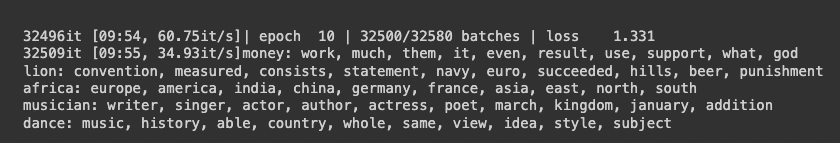

### Results after Epoch 2:

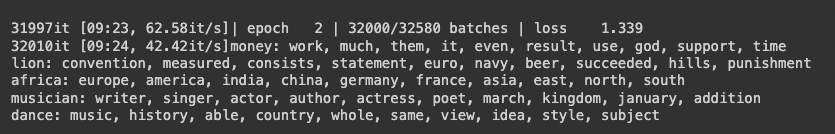